In [1]:
from IPython.display import display, HTML
display(HTML("""
<style>
div.container{width:90% !important;}
div.cell.code_cell.rendered{width:100%;}
div.input_prompt{padding:0px;}
div.CodeMirror {font-family:Consolas; font-size:12pt;}
div.text_cell_render.rendered_html{font size:12pt;}
div.output {font-size:12pt; font-weight:bold;}
div.input{font-family:Consolas; font-size:12pt;}
div.prompt {min width:70px;}
div#toc-wrapper {padding-top:120px;}
div.text_cell_render ul li{font-size:12pt;padding:5px;}
table.dataframe {font-size:12px;}
</style>
"""))

# ※ Quiz : 경주여행과 전주여행에 대해 최빈단어시각화와 유사도분석
- (1) naver open API를 활용하여 네이버지식인 "경주여행", "전주여행"을 각각 500건씩 검색 백업 (naver.csv)
    - 텍스트 전처리 (re.sub(), replace() 이용)
    - 백업파일 결과 : query, no, title, link, description, total_text(title + ' ' + description)
- (2) 품사태깅 및 결과 백업 (naver_pos.csv)
    - query, no, token, pos
- (3) 명사만 추출 백업 (naver_pos_nouns.csv)
    - query, token, pos
- (4) 빈도분석 백업(naver_pos_nouns_count.csv)
    - token, 경주빈도, 전주빈도, 빈도합
- (5) 빈도 시각화(워드클라우드, Text.plot)
    - 워드클라우드 이미지 저장
- (6) 단어간 유사도 분석(Word2Vec, 연관분석)

# 1. naver open API를 활용하여 검색어 500건 추출

In [1]:
from dotenv import load_dotenv
load_dotenv()

True

In [2]:
# .env 가져오기 (방법1)
import os
client_id = os.getenv("CLIENT_ID")
client_secret = os.getenv("CLIENT_SECRET")

In [4]:
# .env 가져오기 (방법2)
from decouple import config
# print(config("CLIENT_ID"))
# print(config("CLIENT_SECRET"))

In [35]:
import requests
import pandas as pd
import json
import re
from html import unescape # description에 &lt; &nbps; 등의 특수문자를 실제 문자로 변경

def get_search_element_return(query, start):
    headers = {
        'X-Naver-Client-Id':client_id,
        'X-Naver-Client-Secret':client_secret
    }
    url = 'https://openapi.naver.com/v1/search/kin'
    params = {'query':query, 'display':100, 'start':start}
    response = requests.get(url, params=params, headers=headers)
    items = response.json()['items']
    result = []# 검색한 정보를 append할 리스트
    for i, item in enumerate(items):
        title = item.get('title').replace('<b>', ' ').replace('</b>', ' ')
        link  = item.get('link')
        description = item.get('description').replace('<b>', ' ').replace('</b>', ' ')
        # 특수문자처리
        description = unescape(description)
        # 영문자, 숫자, 한글을 제외한 문자 제거
        description = re.sub(r'[^a-zA-Z0-9가-힣]', ' ', description)
        description = re.sub('\s+', ' ', description)
        result.append({
            'query':query,
            'no':(start-1)*100 + i+1,
            'title':title,
            'link':link,
            'description':description,
            'total_text':title + ' ' +description
        })
    return result

In [36]:
import time
result_total = [] # 모든 검색 결과
queries = ['전주 여행', '경주 여행']
max_start = 5
for query in queries:
    for start in range(1, max_start+1):
        print(start, query, '읽는 중')
        result_total.extend(get_search_element_return(query, start))
        time.sleep(0.5)
df = pd.DataFrame(result_total)
df.to_csv('data/naver.csv', index=False)

1 전주 여행 읽는 중
2 전주 여행 읽는 중
3 전주 여행 읽는 중
4 전주 여행 읽는 중
5 전주 여행 읽는 중
1 경주 여행 읽는 중
2 경주 여행 읽는 중
3 경주 여행 읽는 중
4 경주 여행 읽는 중
5 경주 여행 읽는 중


# 2. 품사태깅 백업
- query, no, token, pos

In [38]:
import pandas as pd
df = pd.read_csv('data/naver.csv')
df.tail(2)

,query,no,title,link,description,total_text
998,경주 여행,499,경주 여행 가면 볼거 많겠죠??,https://kin.naver.com/qna/detail.naver?d1id=9&...,중학생인데 경주 여행 가볼려고 하는데 볼거 많겠죠 경주 가볼만한곳 입니다 불국사 첨...,경주 여행 가면 볼거 많겠죠?? 중학생인데 경주 여행 가볼려고 하는데 볼거 많겠죠...
999,경주 여행,500,경주여행 !!,https://kin.naver.com/qna/detail.naver?d1id=9&...,경주 여행 을 가려고 하는데 혹시 경주에 폴라로이드 카메라 대여 할 수 있는곳이나...,경주여행 !! 경주 여행 을 가려고 하는데 혹시 경주에 폴라로이드 카메라 대여 ...


In [40]:
df_list = df[['query', 'no', 'total_text']].values.tolist()
df_list[::250]

[['전주 여행',
  1,
  '25년10월5,6,7일  전주여행   전주여행 가볼만한 곳 추천부탁드립니다 25년 10월 초 전주여행 아이들과 함께 가기 좋은 시점이에요 추석에는 문 연 곳이 적을 수 있지만 전주 한옥마을이나 전주비빔밥 맛집은 추천해용 차는 밀릴 가능성이 높으니 미리 출발하는 '],
 ['전주 여행',
  251,
  '[추천해주세요]  전주  당일치기  여행   추천해주세요 전주 당일치기 여행 전주여행 전주맛집 국내여행 전주달봉이 달봉티비 전주여행 코스 전주가볼만한곳 여수여행 여수가볼만한곳 제주도여행 제주도가볼만한곳 여행 전문 인플루언서 전주달봉이입니다 '],
 ['경주 여행',
  1,
  'APEC 기간  경주여행  APEC 기간 경주여행 어떻게 생각하시나요 APEC 기간에 경주여행 은 좋은 방법이에요 역사와 문화가 가득한 도시에서 특별한 경험을 할 수 있을 거에요 즐거운 여행 되세요 '],
 ['경주 여행',
  251,
  ' 경주 여행  코스 어디가★ 가족들이랑 경주여행 을 가려고 하는데 경주 여행 코스를 어떻게 해야할지 모르겟네요 경주 여행 코스 어디가 좋을까요 사실 중학교때 가보고 안가봤어요 경주 여행 코스 가장 핫플레이스만 가보고 싶어요 혹시 경주 여행 코스 다들 ']]

In [47]:
from mecab import MeCab
mecab = MeCab()
stopwords = {'전주', '경주', '여행'}
postagged_list = [] #query, no, token, pos 딕셔너리 list
for i, row in enumerate(df_list):
    query = row[0]
    no = row[1]
    text = row[2]
    tagged_text = mecab.pos(text)
    for token, pos in tagged_text:
        if token not in stopwords:
            postagged_list.append({
                'query' : query,
                'no' : no,
                'token' : token,
                'pos' : pos
            })
df_postagged = pd.DataFrame(postagged_list)
df_postagged.to_csv('data/naver_pos.csv', index=False)

In [48]:
df_postagged.shape

(54115, 4)

# 3. 명사만 추출

In [49]:
import pandas as pd
df_postagged = pd.read_csv('data/naver_pos.csv')
df_postagged.head(1)

,query,no,token,pos
0,전주 여행,1,25,SN


In [51]:
select_pos = ['NNG', 'NNP'] # mecab의 명사 pos tag
df_nouns = df_postagged[df_postagged['pos'].isin(select_pos)]
df_nouns.to_csv('data/naver_pos_nouns.csv', index=False)

# 4. 빈도분석
- token 경주빈도 전주빈도 빈도합

In [52]:
df_nouns = pd.read_csv('data/naver_pos_nouns.csv')
df_nouns.head()

,query,no,token,pos
0,전주 여행,1,곳,NNG
1,전주 여행,1,추천,NNG
2,전주 여행,1,부탁,NNG
3,전주 여행,1,아이,NNG
4,전주 여행,1,시점,NNG


In [56]:
df_token_grp = df_nouns.groupby('query')['token'].value_counts()
df_token_grp = df_token_grp.reset_index(name='token_count')
df_token_grp.head()

,query,token,token_count
0,경주 여행,코스,447
1,경주 여행,추천,424
2,경주 여행,계획,151
3,경주 여행,곳,134
4,경주 여행,맛집,133


In [59]:
df_gj = df_token_grp.loc[df_token_grp['query']=='경주 여행', ['token', 'token_count']]
df_jj = df_token_grp.loc[df_token_grp['query']=='전주 여행', ['token', 'token_count']]
df_gj.head()

,token,token_count
0,코스,447
1,추천,424
2,계획,151
3,곳,134
4,맛집,133


In [60]:
df_jj.head()

,token,token_count
535,코스,459
536,곳,433
537,봉,330
538,맛집,322
539,여수,315


In [64]:
#df_gj(경주 명사 출현횟수), df_jj(전주 명사 출현 횟수) 병합
df_mrg = pd.merge(df_gj, df_jj, on='token', how='outer')
df_mrg.columns = ['token', '경주빈도', '전주빈도']
df_mrg.fillna(0, inplace=True)
df_mrg['경주빈도'] = df_mrg['경주빈도'].astype('int')
df_mrg['전주빈도'] = df_mrg['전주빈도'].astype('int')

In [69]:
df_mrg['빈도합'] = df_mrg['경주빈도'] + df_mrg['전주빈도']
df_mrg['경주비율'] = df_mrg['경주빈도']/df_mrg['빈도합']
df_mrg['전주비율'] = df_mrg['전주빈도']/df_mrg['빈도합']
df_mrg['경주비율'] = df_mrg['경주비율'].apply(lambda x: "{:.2%}".format(x))
df_mrg['전주비율'] = df_mrg['전주비율'].apply(lambda x: "{:.2%}".format(x))
df_mrg.to_csv('data/naver_pos_nouns_count.csv', index=False)
df_mrg.head()

,token,경주빈도,전주빈도,빈도합,경주비율,전주비율
0,코스,447,459,906,49.34%,50.66%
1,추천,424,289,713,59.47%,40.53%
2,계획,151,64,215,70.23%,29.77%
3,곳,134,433,567,23.63%,76.37%
4,맛집,133,322,455,29.23%,70.77%


# 5. 빈도 시각화 (워드 클라우드, Text)
- 전주여행 워드클라우드/경주 여행 워드클라우드

In [71]:
df_nouns = pd.read_csv('data/naver_pos_nouns.csv')
df_nouns.loc[::5000]

,query,no,token,pos
0,전주 여행,1,곳,NNG
5000,전주 여행,273,현대,NNG
10000,경주 여행,54,지,NNG
15000,경주 여행,377,추천,NNG


In [75]:
df_gj_noun_list = df_nouns.loc[df_nouns['query']=='경주 여행', 'token'].to_list()
df_jj_noun_list = df_nouns.loc[df_nouns['query']=='전주 여행', 'token'].to_list()
df_gj_noun_list[:5], df_jj_noun_list[:5]

(['기간', '기간', '생각', '기간', '방법'], ['곳', '추천', '부탁', '아이', '시점'])

In [76]:
gj_text = ' '.join(df_gj_noun_list)
jj_text = ' '.join(df_jj_noun_list)

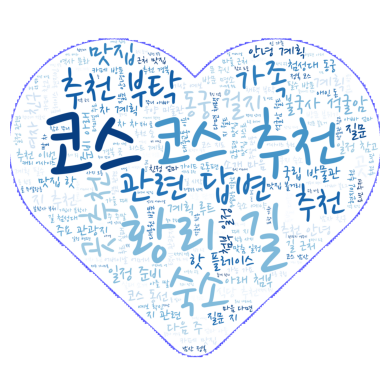

In [84]:
import numpy as np
from PIL import Image
from wordcloud import WordCloud
import matplotlib.pyplot as plt
img = Image.open('data/heart.jpg')
mask = np.array(img)
wordcloud = WordCloud(
    font_path='data/NanumPenScript-Regular.ttf',
    background_color='white',
    colormap='Blues',
    collocations=True, #특정단어 자주 같이 나오면 같이 뿌려 ex 황리길
    max_words=200,
    scale=2,  #이미지 크기의 비율(파일 저장시)
    mask=mask,
    contour_color='blue',
    contour_width=1
).generate(gj_text)
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

In [86]:
#생성된 wordcloud 저장
wordcloud.to_file('data/naver_경주.jpg')

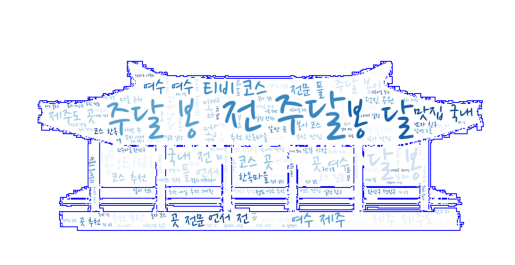

In [87]:
import numpy as np
from PIL import Image
from wordcloud import WordCloud
import matplotlib.pyplot as plt
img = Image.open('data/korea-house-black-fill.png')
mask = np.array(img)
wordcloud = WordCloud(
    font_path='data/NanumPenScript-Regular.ttf',
    background_color='white',
    colormap='Blues',
    collocations=True, #특정단어 자주 같이 나오면 같이 뿌려 ex 황리길
    max_words=200,
    scale=2,  #이미지 크기의 비율(파일 저장시)
    mask=mask,
    contour_color='blue',
    contour_width=1
).generate(jj_text)
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

In [88]:
wordcloud.to_file('data/naver_전주.jpg')

# 빈도수 시각화(nltk.Text)

In [98]:
df_gj_noun_list = df_nouns.loc[df_nouns['query']=='경주 여행', 'token'].to_list()
df_jj_noun_list = df_nouns.loc[df_nouns['query']=='전주 여행', 'token'].to_list()

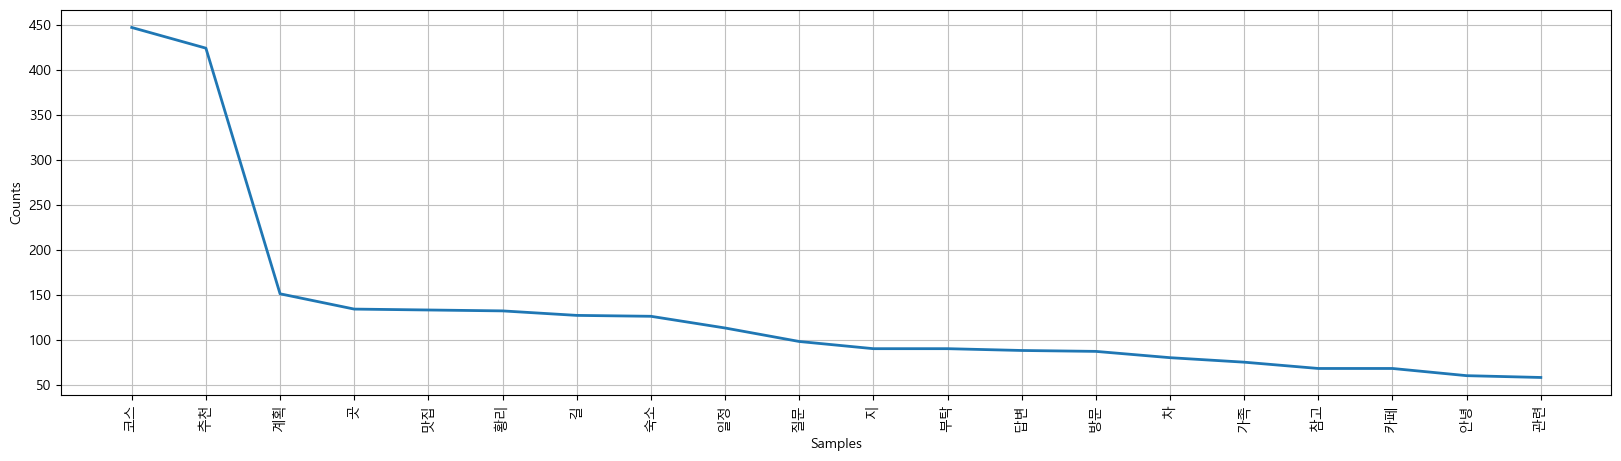

In [99]:
import nltk
data_text = nltk.Text(df_gj_noun_list)
plt.figure(figsize=(20,5))
plt.rc('font', family='Malgun Gothic')
data_text.plot(20)
plt.show()

In [103]:
word, counts = zip(*data_text.vocab().most_common(20))
print(word)
print(counts)

('코스', '추천', '계획', '곳', '맛집', '황리', '길', '숙소', '일정', '질문', '지', '부탁', '답변', '방문', '차', '가족', '참고', '카페', '안녕', '관련')
(447, 424, 151, 134, 133, 132, 127, 126, 113, 98, 90, 90, 88, 87, 80, 75, 68, 68, 60, 58)


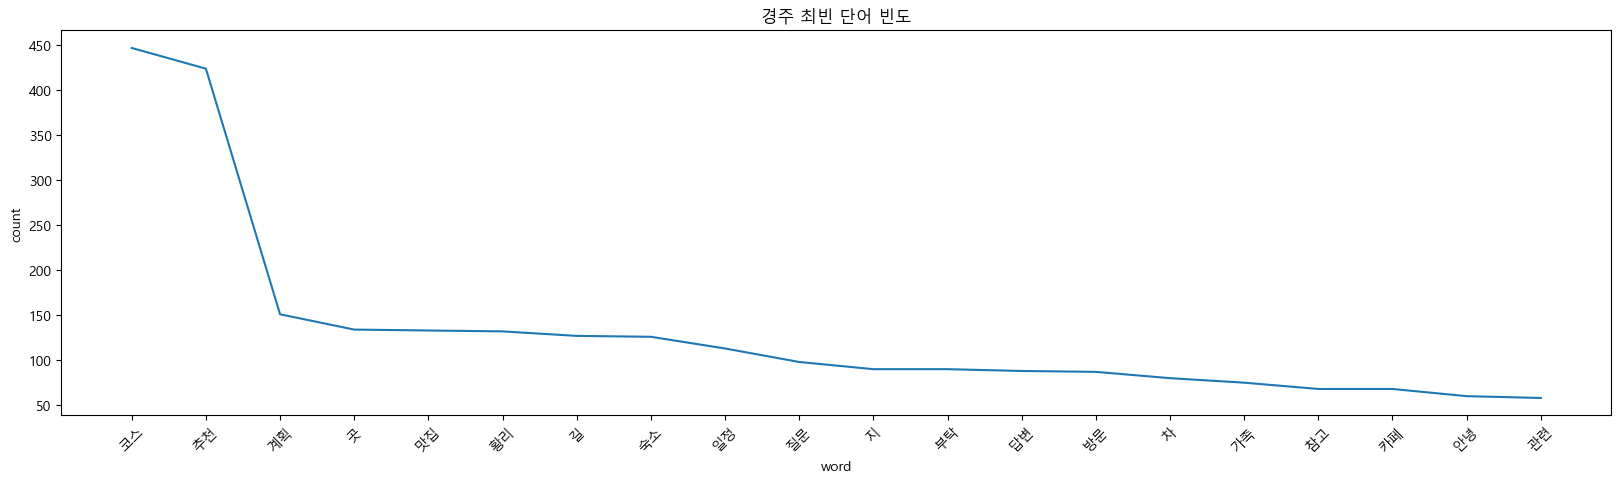

In [104]:
plt.figure(figsize=(20,5))
plt.plot(word, counts)
plt.xticks(rotation=45)
plt.xlabel('word')
plt.ylabel('count')
plt.title('경주 최빈 단어 빈도')
plt.show()

# 6. 유사도 분석
## Word2Vec

In [106]:
df = pd.read_csv('data/naver.csv')
df.sample()

,query,no,title,link,description,total_text
590,경주 여행,91,경주여행 추천 좀 해주세요,https://kin.naver.com/qna/detail.naver?d1id=9&...,가야하는 경주 여행 지도 추천 부탁합니다 경주보문단지내에 위치한 우양미술관은 국내...,경주여행 추천 좀 해주세요 가야하는 경주 여행 지도 추천 부탁합니다 경주보문단...


In [107]:
total_text_list = df['total_text'].to_list()

In [109]:
select_pos = ['NNP', 'NNG']
불용어 = {'여행'}
mecab = MeCab()
total_noun_list = []
for total_text in total_text_list:
    noun_list = [token for token, tag in mecab.pos(total_text) if tag in select_pos and token not in 불용어 and len(token)>1]
    total_noun_list.append(noun_list)
print(total_noun_list[:2])

[['전주', '전주', '추천', '부탁', '전주', '아이', '시점', '추석', '전주', '한옥마을', '전주비빔밥', '맛집', '추천', '해용', '가능', '출발'], ['전주', '주요', '관광지', '도보', '이동', '전주', '계획', '주역', '한옥마을', '도보', '정도', '정도', '대부분', '택시', '버스', '이용', '택시', '정도', '도착', '요금', '정도', '부담']]


In [110]:
from gensim.models import Word2Vec
model = Word2Vec(total_noun_list, window=10, min_count=2, workers=-1, sg=1)

In [111]:
model.wv.most_similar('전주')

[('식사', 0.3595535457134247),
 ('동선', 0.2897421419620514),
 ('리스트', 0.275379478931427),
 ('덕진구', 0.2731468081474304),
 ('현재', 0.2580290138721466),
 ('가격', 0.2295033037662506),
 ('반려', 0.22023281455039978),
 ('답변', 0.21883943676948547),
 ('한옥마을', 0.21617142856121063),
 ('허락', 0.2135322391986847)]

In [112]:
model.wv.most_similar('경주')

[('호수', 0.3641005754470825),
 ('여름', 0.21867415308952332),
 ('배차', 0.21632219851016998),
 ('경기전', 0.2159893959760666),
 ('인근', 0.21469099819660187),
 ('황동', 0.2134207934141159),
 ('다랭이', 0.20914912223815918),
 ('봉길', 0.20906010270118713),
 ('남편', 0.2070489227771759),
 ('체계', 0.20607852935791016)]

## 연관분석

In [114]:
print(total_noun_list[::250])

[['전주', '전주', '추천', '부탁', '전주', '아이', '시점', '추석', '전주', '한옥마을', '전주비빔밥', '맛집', '추천', '해용', '가능', '출발'], ['추천', '전주', '당일치기', '추천', '전주', '당일치기', '전주', '전주', '맛집', '국내', '주달', '티비', '전주', '코스', '전주', '여수', '여수', '제주', '제주도', '전문', '언서', '주달', '봉이'], ['기간', '경주', '기간', '경주', '생각', '기간', '경주', '방법', '역사', '문화', '도시', '특별', '경험'], ['경주', '코스', '가족', '경주', '경주', '코스', '경주', '코스', '중학교', '경주', '코스', '플레이스', '경주', '코스']]


In [116]:
%%time
from apyori import apriori
rules = apriori(total_noun_list, min_support=0.15, min_confidence=0.3, min_lift=1)
rules = list(rules)
len(rules)

CPU times: total: 31.2 ms
Wall time: 34.2 ms


130

In [119]:
idx = 0
rules_df = pd.DataFrame(None, columns=['lhs', 'rhs', '지지도', '신뢰도', '향상도'])
rules_df
for row in rules:
    support = row[1]
    ordered_st = row[2]
    for item in ordered_st:
        lhs = item[0]
        lhs = ','.join([x for x in lhs])
        rhs = item[1]
        rhs = ','.join([x for x in rhs])
        confidence = item[2]
        lift = item[3]
        rules_df.loc[idx] = [lhs, rhs, support, confidence, lift]
        idx += 1
rules_df = rules_df.sort_values(by=['신뢰도', '향상도'], ascending=False)
rules_df.head(10)

,lhs,rhs,지지도,신뢰도,향상도
107,"여수,국내",티비,0.150,1.0,6.060606
137,"주달,국내",티비,0.155,1.0,6.060606
143,"코스,국내",티비,0.155,1.0,6.060606
167,"여수,맛집",티비,0.155,1.0,6.060606
233,"여수,주달",티비,0.155,1.0,6.060606
239,"여수,코스",티비,0.155,1.0,6.060606
312,"여수,국내","티비,맛집",0.150,1.0,6.060606
317,"여수,국내,맛집",티비,0.150,1.0,6.060606
382,"주달,국내","티비,맛집",0.155,1.0,6.060606
387,"주달,국내,맛집",티비,0.155,1.0,6.060606
